## Some setup

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
print('Using TensorFlow ',tf.__version__)
tfd = tfp.distributions

Using TensorFlow  2.4.1


In [ ]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
# Code can run seamlessly on a GPU, 
#just change Colab runtime type in the 'Runtime' menu.
if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")

Using a GPU


# Bayesian Deep Learning in TensorFlow Probability and Tensorflow 2.0

TensorFlow Probability is a library for probabilistic reasoning and statistical analysis in TensorFlow. 

Two types of tools: 
#### Tools for building models: 

- **Distributions**: Collection of summary statistics, exactly like in every other probabilistic library. Only a few differences to take advantage of vector processing hardware.
- Bijectors: library for transforming random variables 
- **Probabilistic Layers and losses**: Allows to build Monte Carlo approximations to otherwise intractable calculations probabilistic 

#### Tools for doing inference on the models :

- Markov Chain MC 
- **Variational inference** 
- Optimizers 



### Distributions
A tfp.distributions.Distribution is a class with two core methods: `sample` and `log_prob`

In [ ]:
# A standard normal
normal = tfd.Normal(loc=0., scale=1.)
print(normal)

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


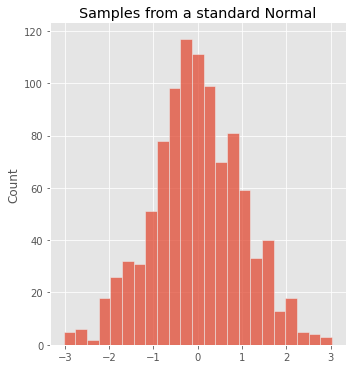

In [ ]:
# Plot 1000 samples from a standard normal
samples = normal.sample(1000)
sns.displot(samples)
plt.title("Samples from a standard Normal")
plt.show()

In [ ]:
# Compute the log_prob of a point in the event space of `normal`
normal.log_prob(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

In [ ]:
# Compute the log_prob of a few points
normal.log_prob([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.4189385, -0.9189385, -1.4189385], dtype=float32)>

TensorFlow Probability Distributions have shape semantics:
*   Batch shape: a collection of Distributions with distinct parameters 
*   Event shape: shape of samples from the Distributions 

In [ ]:
# Create a batch of 3 normals with different means but same stdv
normals = tfd.Normal([-2.5, 0., 2.5], 1.)  # The scale parameter broadacasts!
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)

Batch shape: (3,)
Event shape: ()


In [ ]:
# Sample 1000 events from each distribution in the batch
samples = normals.sample(1000)
print("Shape of samples:", samples.shape)

Shape of samples: (1000, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


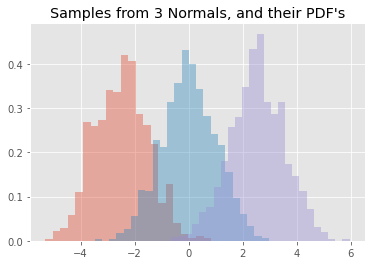

In [ ]:
# Summarizing visually
for i in range(3):
  sns.distplot(samples[:, i], kde=False, norm_hist=True)
plt.title("Samples from 3 Normals, and their PDF's")
plt.show()

In [ ]:
# Create one 2-dimensional gaussian 
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag = [1., 1.])
print("Batch shape:", mvn.batch_shape)
print("Event shape:", mvn.event_shape)

Batch shape: ()
Event shape: (2,)


Samples shape: (1000, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


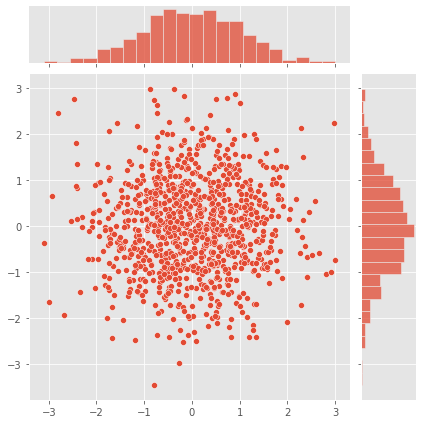

In [ ]:
samples = mvn.sample(1000)
print("Samples shape:", samples.shape)
g = sns.jointplot(samples[:, 0], samples[:, 1], kind='scatter')
plt.show()

We can obtain the same result by using tfp.Independent setting reinterpreted_batch_ndims=1. This takes a distribution and returns a new distribution with the batch shape moved to the event shape. 

In [ ]:
# Multivariate normal using tfp.Independent
normal = tfd.Normal(loc=[0., 0.], scale=1.)
print('log_prob = ',normal.log_prob([0.5,0.5]))#probability of separate experiments
print("Batch shape:", normal.batch_shape)
print("Event shape:", normal.event_shape)

joint = tfd.Independent( tfd.Normal(loc=[0., 0.], scale=1.), reinterpreted_batch_ndims=1)
print("Batch shape:", joint.batch_shape)
print("Event shape:", joint.event_shape)
print('log_prob = ',joint.log_prob([0.5,0.5])) #one probability for entire dataset

log_prob =  tf.Tensor([-1.0439385 -1.0439385], shape=(2,), dtype=float32)
Batch shape: (2,)
Event shape: ()
Batch shape: ()
Event shape: (2,)
log_prob =  tf.Tensor(-2.087877, shape=(), dtype=float32)


Samples shape: (1000, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


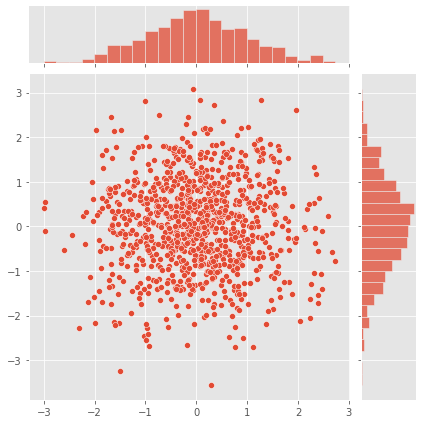

In [ ]:
samples = joint.sample(1000)
print("Samples shape:", samples.shape)
g = sns.jointplot(samples[:, 0], samples[:, 1], kind='scatter')
plt.show()

## Linear Regression with TFP Probabilistic Layers



#### Plotting utils

In [ ]:
# Some plotting utils 
def plot_data(x, t, legend=None):
    plt.scatter(x, t, marker='o', c="k", s=20, label='Training data')
def plot_predictive(x, yhat, y_label='Prediction', stddev_args=None, linewidth=3, plot_xy_labels=True):

    plt.plot(x, yhat, 'r', label=y_label, linewidth=linewidth)

    if stddev_args is not None:
      std = stddev_args
      plt.plot(x, yhat + 2 * std, 'g', linewidth=linewidth, label=r'mean + 2 stddev');
      plt.plot(x, yhat - 2 * std, 'g',linewidth=linewidth, label=r'mean - 2 stddev');

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')

#### Generate data

Let's first generate some data to fit

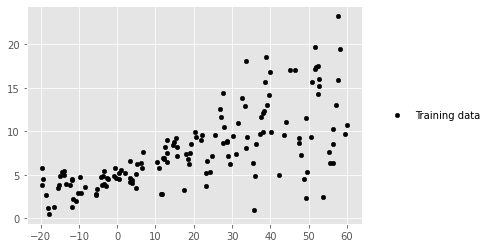

In [ ]:
# Synthesize dataset
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()
plot_data(x,y)
plt.legend(loc='center left', framealpha=0., bbox_to_anchor=(1.05, 0.5))

### Classical model

We have learned that the loss function in a deep learning model is usually just the negative log-likelihood (NLL) of the probabil istic model we assumed for our data. For the case of linear regression we generally use the MSE, which is nothing more than the $-log( p(t| \mathbf{x}, \mathbf{w}))$ where $p(t| \mathbf{x}, \mathbf{w}) = \mathcal{N}(t|\hat{y}, 1)$ and $\hat{y}(\mathbf{x}, \mathbf{w})$ is the output of our network.

TFP allows to specify a probabilistic model, so that the loss function can be implemented directly as simply the NLL.

#### Deterministic model

Let's build a classical model for linear regression. We have one standard keras layer `Dense` that outputs one float. This float is then passed through the probabilistic layer `DistributionLambdaLayer`. 

> *A `DistributionLambda` is minimially characterized by a function that returns a tfp.distributions.Distribution instance.*

This is a special layer that uses a Python lambda to construct a distribution conditioned on the layer inputs. In this case the `DistributionLambda` layer outputs a normal distribution. The float output by the `Dense` layer parametrizes the mean of this normal. Note that we are assuming the variance of the distribution to be fixed at 1. 


In [ ]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

Let's train our deterministic model. The `DistributionLambda` layer allowed us to input our probabilistic model into the network. This means that we can define our NLL loss function just as what it is, using probability distributions.

In [ ]:
# Train
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);


The Keras `Dense` layer has two components: the kernel matrix and the bias vector. The training of the model gives us deterministic estimates of these weights. These are shown below.

In [ ]:
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())
print('slope = %.5f, bias = %.5f' % (w,b))

slope = 0.13592, bias = 5.12341


Now let's deploy our trained model on some unseen data. Note how once we instantiate the model with some test points, we get back a distribution instance. This means that the output of our model will be itself a random variable. Since we have only one output node, we are predicting the mean of the distribution, according to our probabilistic model 

$$p(t|\mathbf{x^*}, \mathbf{w}_{ML}, 1) = \mathcal{N} (t|y(\mathbf{x^*}, \mathbf{w}_{ML}), 1)$$

In [ ]:
# Test
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

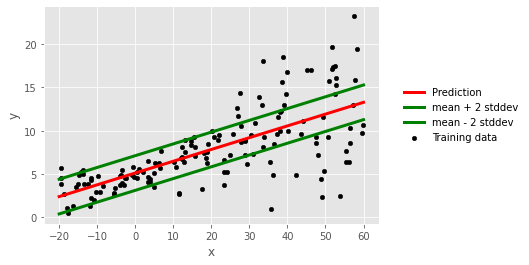

In [ ]:
plot_data(x,y)
plot_predictive(x_tst, yhat.mean(), stddev_args=yhat.stddev())
plt.legend(loc='center left', framealpha=0., bbox_to_anchor=(1.05, 0.5))

So far we have assumed the variance of our probabilistic model to be fixed at 1. However, we can see that as $x$ increass, the variance of $y$ also increases and with our current model we are not capturing this feature in the data.  To fix this, we can learn the variance too. 



#### Aleatoric uncertainty
We make the first `Dense` layer output two floats instead of one. This time one float is parametrizing the mean of the normal distribution, while second parametrizes the variance. 

In [ ]:
# Build model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),  # <-- two output nodes!
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Train
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# test
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

In [ ]:
w = np.squeeze(model.layers[-2].kernel)
b = np.squeeze(model.layers[-2].bias)
print('       mu        stdv')
print('slope: {}'.format(w))
print('bias:  {}'.format(b))

       mu        stdv
slope: [0.12586948 1.003538  ]
bias:  [ 5.20333  15.106942]


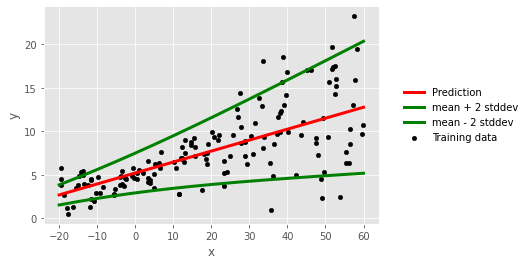

In [ ]:
plot_data(x,y)
plot_predictive(x_tst, yhat.mean(), stddev_args=yhat.stddev())
plt.legend(loc='center left', framealpha=0., bbox_to_anchor=(1.05, 0.5))

teststdv = yhat.stddev()

So now we have also learned the standard deviation! Note that this is what we call the aleatoric uncertainty. The data itself had an irreducible variance and we learned it. 

However, how can we be sure that we had enough data to claim that our point estimates for the parameters of the network are correct? We know that there can be some epistemic uncertainty associated to the model parameters and that we can address this issue by using a Bayesian neural network, which can learn probability distributions over the weights instead of point estimates.  In the previous notebook we built our DenseVariational layer from scratch for demonstration purposes. However, TFP has this already implemented for us. 

### Bayesian neural network


#### Epistemic uncertainty 



The `DenseVariationalLayer` in TFP allows us to build probabilistic layers. This layer uses variational inference to fit a candidate posterior to the distribution over both the kernel matrix and the bias terms which are otherwise used in a manner similar to tf.keras.layers.Dense. Recall that the loss function when performing variational inference is given by the negative ELBO

$$ J(\mathbf{x}, \mathbf{w}) = KL[ q(\mathbf{w}| \lambda) | p(\mathbf{w})] - \mathbb{E}_{q(\mathbf{w} | \lambda)} [ \text{log} p(D | \mathbf{w})]$$

`DenseVariationalLayer` approximates the KL loss term is computed by sampling only one weight. We call the first term the *KL loss* and the second term the *likelihood loss*. Note that the likelihood loss, being data-dependent, needs to be computed at the end of the forward pass. The second term is computed analytically and then added to the layer as a regularization loss (similarly to a classical NN). The losses are added together by Keras under the hood. 

As always with BNNs, we need to first define our choice of approximate posterior and of prior distributions over the weights. The optimization will regularize the variational posterior to be close to our prior.



We assume the posterior distribution to be a multivariante normal distribution. Each one dimensional gaussian represents the uncertainty on a given weight and is parameterized by the trainable variatonal parameters $\mu$ and $\sigma$. Note that since $\sigma$ is always positive we don't train directly on $\sigma$ but train on $\rho$ and then apply the transformation $\sigma = \text{log} ( 1 + \text{exp}(\rho))$. 

We'll use the `tfp.layers.VariableLayer`. This layer implements the mathematical function $f(x) = c$ where $c$ is a constant, i.e., unchanged for all $x$. So it simply returns the value of a trainable parameter (in this case the $n \times 2$ variational parameters). This parameter is passed as input to the `DistributionLambda` layer. 

In [ ]:
# Specify the approximate posterior over `keras.layers.Dense` `kernel` and `bias`
def posterior(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size # n weights
  c = np.log(np.expm1(1.)) 
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype), # 2 x n variational parameters
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

We also need to specify the prior distribution over the weights. For the prior we'll use a multivariate normal distribution with a trainable mean and standard deviation 1.

In [ ]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

Now let's build and train our Bayesian neural network.

In [ ]:
# Build BNN model
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Train
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);



Note that the KL loss instead is data-independent and can be computed layer-wise for each weight. To account for this we scale the KL loss by a *kl_weight* equal to the size of the number of examples per epoch. 


In [ ]:
model.summary()
[print(np.squeeze(w.numpy())) for w in model.weights];

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 1)                 6         
_________________________________________________________________
distribution_lambda_2 (Distr multiple                  0         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
[ 0.13242753  5.13126    -4.1632156  -2.399602  ]
[0.13520513 5.133051  ]


In [ ]:
# Test
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)


Note how we went back to having only one output node parametrizing the mean of the probabilistic model. Let's try to make one prediction using our trained BNN. 

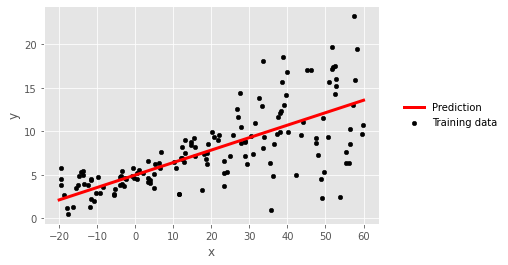

In [ ]:
plot_data(x,y)
plot_predictive(x_tst, yhat.mean())
plt.legend(loc='center left', framealpha=0., bbox_to_anchor=(1.05, 0.5))

Now let's make several predictions...

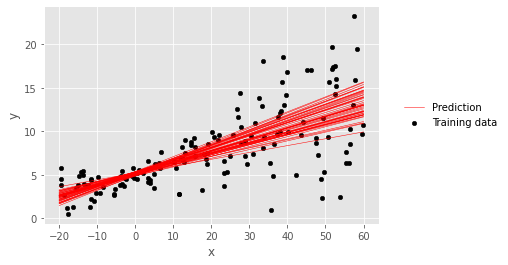

In [ ]:
# Make predictions.
plot_data(x,y)
for i in range(50):
  yhat = model(x_tst)
  plot_predictive(x_tst, yhat.mean(), linewidth=0.5)
  if(i==0):
    plt.legend(loc='center left', framealpha=0., bbox_to_anchor=(1.05, 0.5))


We see that the mean predictions vary each time. This is because every time we call model.predict(), we are sampling a new set of weights from the trained posterior distribution. The variance in the mean prediction here is what we call epistemic uncertainty 

#### Putting it all together: aleatoric & epistemic uncertainty

Now let's put everything together and use TFP layers' composable API to create a BNN capable of reporting both the epistemic and aleatoric uncertainty. 

In [ ]:
# Build model
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior, prior_trainable, kl_weight=1/x.shape[0]), # 2 ouput nodes!
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Train
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Test
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.14488113  2.7388375   5.172564    3.8057635  -3.38331    -0.95635545
 -2.1435268  -0.15732992]
[0.11206204 2.8038187  5.1623034  3.8592196 ]


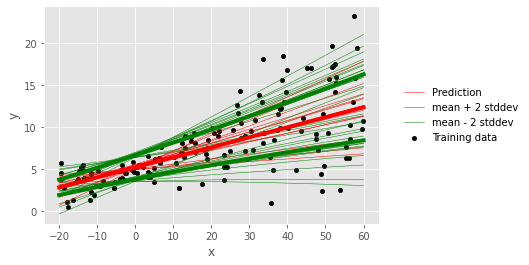

In [ ]:
# Make predictions.
plot_data(x,y)
m = 0
s = 0
N = 15 # number of predictions
for i in range(N):
  yhat = model(x_tst)
  m += np.squeeze(yhat.mean())
  s += np.squeeze(yhat.stddev())
  plot_predictive(x_tst, yhat.mean(), stddev_args=yhat.stddev(), linewidth=0.5)
  if(i==0):
    plt.legend(loc='center left', framealpha=0., bbox_to_anchor=(1.05, 0.5))

m = m/N
s = s/N
plot_predictive(x_tst, m, stddev_args=s, linewidth=4)

As in the previous solution we have an ensemble of models. However, now they not only report the uncertainty in the choice of weights, but they also report the variability of $y$ as a function of $x$. In fact, we have both an ensemble of standard deviations associated with the variance present in the $y$ axes, as well as an ensemble of mean regressions showing how confident we are in our predictions. 

#### Remark

As a final note, you might have noticed that we trained on the prior! This type of training corresponds to *Empirical Bayes* (also known as *Type-II Maximum Likelihood* or *Evidence approximation*). This method maximizes the data evidence with respect to the prior parameters to find the best estimates. We used this method so that we didn't have to specify a prior for the weights in our network, as it can be hard to guess if we have no previous knowledge about the data and a very poor choice can affect the posterior distribution. A fully Bayesian approach would require defining a prior for all the model parameters, thus also for the prior's ones, and perform Bayesian inference on all of them. 